In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_predict, GridSearchCV
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings("ignore")

# Model fitting

Next step, I'll try fitting a few models to the data to see which one yields the most accurate predictions.In this notebook we'll try the below models:
- Multi-linear Regression (With Feature Selection and Lasso and Ridge Corrections).
- Random Forest Regression.
- Custom Model using keras

In [19]:
#Reading in the table
df = pd.read_csv('./Interim Data/cleaned_train.csv')
df.head()

,Norm,Feedr,PosN,Artery,RRAe,RRNn,RRAn,PosA,RRNe,LotFrontage,...,ExMaterial_Wd Sdng+VinylSd,ExMaterial_Wd Sdng+WdShing,ExMaterial_Wd Shng+BrkFace,ExMaterial_Wd Shng+CemntBd,ExMaterial_Wd Shng+HdBoard,ExMaterial_Wd Shng+MetalSd,ExMaterial_Wd Shng+Stucco,ExMaterial_Wd Shng+VinylSd,ExMaterial_Wd Shng+Wd Sdng,ExMaterial_Wd Shng+WdShing
0,1,0,0,0,0,0,0,0,0,65.0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,80.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,68.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,60.0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,84.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# X and y creation
y = df['SalePrice']
X = df.drop('SalePrice',axis=1).astype('float64')

# Linear Regression

### Original

I am using mean absolute error as the metric here because 1) Mean absolute error weighs all errors similarly, which suits us here since we don't need to penalize large errors beyond their value. For example: an error of 1000 is twice as bad as an error of 500, and only twice as bad. 2) R^2 isn't as interpretable as MAE in terms of preictive power, and can make the model prone to overfitting.

First, let's run a Linear Regression model on the data as it is after the EDA process in the other notebook. This can help provide us with a baseline to compare the other models against.

In [30]:
import statsmodels.api as sm

#fit linear regression model
model = sm.OLS(y, X).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     54.38
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:03:02   Log-Likelihood:                -16683.
No. Observations:                1460   AIC:                         3.389e+04
Df Residuals:                    1199   BIC:                         3.527e+04
Df Model:                         260                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Norm                

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
y_pred = cross_val_predict(reg, X, y, cv=5)
mean_absolute_error(y_pred, y)

19428.42771662252

From the above OLS result, we have the following information:
* Prob (F-statistic): it is very small, so that means that our model is overall significant.
* Omnibus / Prob (Omnibus): the residuals are not distributed normally and are skewed.
* We have a lot of parameters that aren't significant based on the T-test, though we have to keep in mind with such a large nubmer of parameters Type I and Type II errors are going to happen.

Since there are some issues with the residual distribution according to the OLS report, we'll check that the 4 assumptions of Linear Regression are met:
* Normal Residuals.
* Constant Variance across different Y values.
* Independence - assumed since large sample.
* No Heteroscedacity.

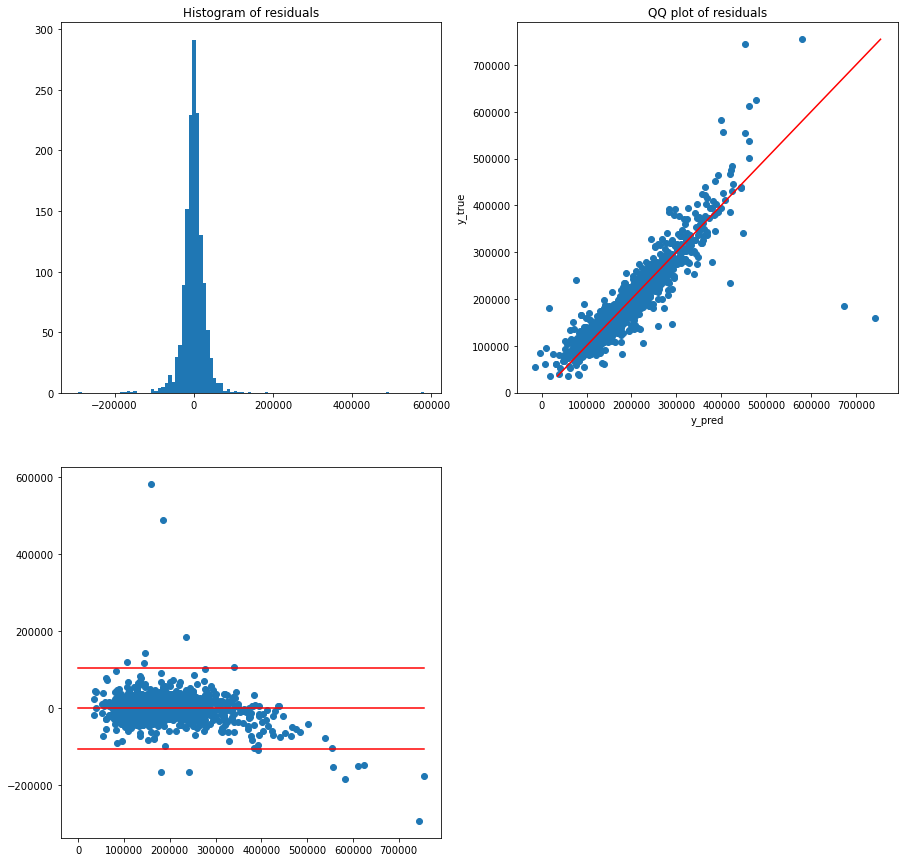

In [5]:
#Check normal distribution of Residuals
import matplotlib.pyplot as plt

def test_linreg(y_pred, y):
    residuals = y_pred - y

    fig = plt.figure(figsize=(15,15))
    #histogram
    ax1 = plt.subplot(2,2,1)
    ax1.hist(residuals, bins=100)
    ax1.set_title('Histogram of residuals')

    #qq plot
    ax2 = plt.subplot(2,2,2)
    ax2.scatter(y_pred,y)
    ax2.plot([min(y),max(y)],[min(y),max(y)], color='red')
    ax2.set_title('QQ plot of residuals')
    ax2.set_ylabel('y_true')
    ax2.set_xlabel('y_pred')

    #Heteroscedasity test
    ax3 = plt.subplot(2,2,3)
    ax3.scatter(y, residuals)
    ax3.plot([0,max(y)],[0,0], color='red')
    ax3.plot([0,max(y)],[-3*residuals.std(),-3*residuals.std()], color='red')
    ax3.plot([0,max(y)],[3*residuals.std(),3*residuals.std()], color='red')
    plt.show()
    
    return residuals
    
residuals = test_linreg(y_pred, y)

The residuals mostly follow a bell curve and the QQ plot appears to have a slope of 1. However, the residuals are skewed to the right, and there are several outliers. 

In [6]:
(residuals.quantile(0.975) - residuals.quantile(0.025))/residuals.std()

3.204762228594042

### Log the Target

Let's try training the Linear Regression with the log of the SalePrice, and exponentiate the output. Based on the results shown below, it looks like logging the SalePrice yields a lower mean absolute error and better conformity with the assumptions of linear regression.

In [7]:
reg = LinearRegression()
y_log = np.log(y)
y_pred = cross_val_predict(reg, X, y_log, cv=5)
mean_absolute_error(np.exp(y_pred), y)

16709.707919152876

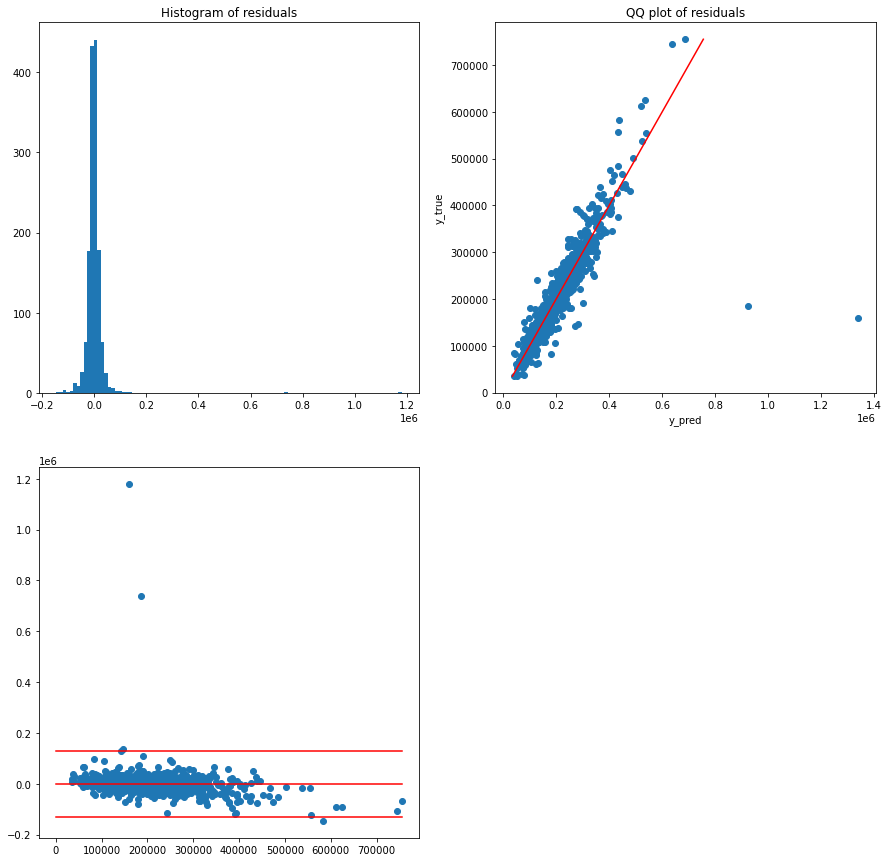

In [8]:
residuals = test_linreg(np.exp(y_pred), y)

In [9]:
(residuals.quantile(0.975) - residuals.quantile(0.025))/residuals.std()

2.172356749278653

There, however, does exist some outliers. Let's examine these.

In [10]:
#Check the outliers
pd.set_option('display.max_columns',1000)
df[residuals > 0.5e6]

,Norm,Feedr,PosN,Artery,RRAe,RRNn,RRAn,PosA,RRNe,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,SalePrice,HasGarage,DiffHouseGarageYrs,HasLowGarageDiff,Has2ndFlr,Grg_ALQ_Area,Grg_BLQ_Area,Grg_GLQ_Area,Grg_LwQ_Area,Grg_Rec_Area,IsAvgGCond,IsAvgGQual,AvgRmSize,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,ExMaterial_AsbShng,ExMaterial_AsbShng+BrkFace,ExMaterial_AsbShng+VinylSd,ExMaterial_AsbShng+Wd Sdng,ExMaterial_AsphShn,ExMaterial_AsphShn+HdBoard,ExMaterial_AsphShn+MetalSd,ExMaterial_Brk Cmn+BrkComm,ExMaterial_Brk Cmn+Plywood,ExMaterial_BrkFace,ExMaterial_BrkFace+Wd Sdng,ExMaterial_CBlock,ExMaterial_CmentBd+CemntBd,ExMaterial_CmentBd+Stucco,ExMaterial_HdBoard,ExMaterial_HdBoard+BrkFace,ExMaterial_HdBoard+Plywood,ExMaterial_HdBoard+Stone,ExMaterial_HdBoard+VinylSd,ExMaterial_HdBoard+WdShing,ExMaterial_ImStucc,ExMaterial_ImStucc+HdBoard,ExMaterial_ImStucc+Plywood,ExMaterial_ImStucc+VinylSd,ExMaterial_ImStucc+Wd Sdng,ExMaterial_MetalSd,ExMaterial_MetalSd+HdBoard,ExMaterial_Other+VinylSd,ExMaterial_Plywood,ExMate

Let's remove these outliers and then re-run the model

In [11]:
df = df.drop([523,1298],axis=0)

In [12]:
y = df['SalePrice']
X = pd.get_dummies(df.drop('SalePrice',axis=1))

reg = LinearRegression()
y_pred = cross_val_predict(reg, X, np.log(y), cv=5)
mean_absolute_error(np.exp(y_pred), y)

14661.955531145744

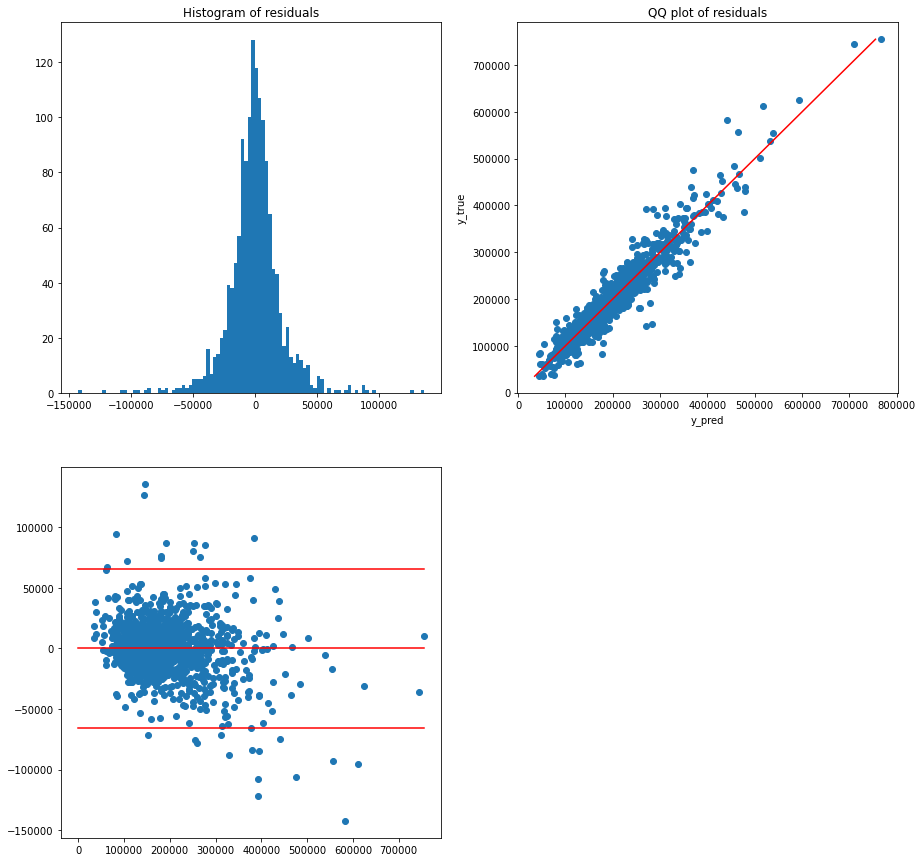

In [13]:
#Check normal distribution of Residuals
import matplotlib.pyplot as plt
residuals = test_linreg(np.exp(y_pred), y)

In [14]:
(residuals.quantile(0.975) - residuals.quantile(0.025))/residuals.std()

4.0088026222056845

I'll save a csv file of the last version of the dataset, the one with the SalePrice variable logged and the outliers removed.

In [22]:
df_med = pd.concat([X,np.log(df['SalePrice'])],axis=1)
df_med.to_csv('./Interim Data/logged_outlier_removed.csv',index=False)

## Feature Selection and Regularization

Since there were a lot of redundant and insignificant features, let's see if removing some of those features would help us achieve more accurate results. Here we'll test the below feature selection methods:
- VIF
- Forward Selection
- Backward Selection

As well as some regularization methods:
- Ridge
- Lasso

In [51]:
#Reading in the Data
df_med = pd.read_csv('./Interim Data/logged_outlier_removed.csv').astype('float')

# X and y creation
y = df_med['SalePrice']
X = df_med.drop('SalePrice',axis=1)

### VIF

VIF is a filter feature selection method, which is when a subset of features are selected based on a certain criteria / value (in this case VIF) independent of the exact Machine Learning Algorithm the features will be used in.

VIF (Variance Inflation Factor) is a numerical measurement of a feature's multicollinearity with other features. A larger VIF means the the feature is more correlated with other features and should be dropped, and is a useful metric to filter out intercorrelated metrics, as we have here. As a rule of thumb, VIFs higher than 5 are considered signs of multicollinearity and should be removed, though this threshold is arbitrary.

In [38]:
def vif_reduction(x, thresh = 5):
    output = x.copy()
    k = output.columns
    vif = [(variance_inflation_factor(output.values,i), k[i]) for i in range(len(k))]
    for i, col in vif:
        if i > thresh:
            output = output.drop(col, axis=1)
    return output

for t in list(range(5,20,1)):
    vif_features = vif_reduction(X, thresh = t)
    reg = LinearRegression()
    y_pred = cross_val_predict(reg, vif_features, y, cv=5)
    mae = mean_absolute_error(np.exp(y_pred), np.exp(y))
    print('Threshold = {}, MAE = {}'.format(t,mae))

Threshold = 5, MAE = 25889.81698563984
Threshold = 6, MAE = 21734.580353999318
Threshold = 7, MAE = 21589.755077625006
Threshold = 8, MAE = 21589.755077625006
Threshold = 9, MAE = 20076.346864677394
Threshold = 10, MAE = 20076.346864677394
Threshold = 11, MAE = 20076.346864677394
Threshold = 12, MAE = 20076.346864677394
Threshold = 13, MAE = 20085.54365465863
Threshold = 14, MAE = 20191.265516484054
Threshold = 15, MAE = 20207.41552061216
Threshold = 16, MAE = 20207.41552061216
Threshold = 17, MAE = 20207.41552061216
Threshold = 18, MAE = 20207.41552061216
Threshold = 19, MAE = 20207.41552061216


In [6]:
vif_features = vif_reduction(X, thresh = 9)
vif_features.columns

Index(['PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe', 'LotFrontage',
       'LotArea', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'DiffHouseGarageYrs',
       'HasLowGarageDiff', 'IsAvgGCond', 'IsAvgGQual', 'RoofMatl_ClyTile'],
      dtype='object')

It seems that the best VIF threshold for linear regression would be 9.

### Forward Selection

Both Forward and Backward Selections are wrapper feature selection methods, which means that features' importances are determined using the output of a certain Machine Learning algorithm. Based on the performance of the model with the selected filters variables are added or removed.

First, we are going to use Forward Selection, which is adding features, from an initial state of 0 features, to a model based on the scoring criteria. It stops when adding new features won't significantly improve the model.

In [32]:
from sklearn.feature_selection import SequentialFeatureSelector
from tqdm import tqdm

feature_selections = []
for i in tqdm(range(1,len(X.columns))):
    reg = LinearRegression()
    for_sel = SequentialFeatureSelector(reg,n_features_to_select=i,direction='forward',scoring='neg_mean_absolute_error')
    for_sel_features = for_sel.fit_transform(X)
    y_pred = cross_val_predict(reg, for_sel_features, y, cv=5)
    feature_selections.append(mean_absolute_error(np.exp(y_pred), np.exp(y)))
    
print(feature_selections.index(min(feature_selections))+1, min(feature_selections))

100%|██████████| 288/288 [4:15:41<00:00, 53.27s/it]  

148 15747.718468375391


It seems that the best VIF threshold for linear regression would be 9.

### Backward Elimination

In contrast to Forward Selection, Backward Elimination is removing features, from an initial state when all features are included, from a model based on their lack of significance and improvement in regards to the scoring criteria. 

It stops when removing features won't significantly improve the model.

In [33]:
from sklearn.feature_selection import SequentialFeatureSelector
from tqdm import tqdm

feature_selections = []
for i in tqdm(range(1,len(X.columns))):
    reg = LinearRegression()
    for_sel = SequentialFeatureSelector(reg,n_features_to_select=i,direction='backward',scoring='neg_mean_absolute_error')
    for_sel_features = for_sel.fit_transform(X)
    y_pred = cross_val_predict(reg, for_sel_features, y, cv=5)
    try:
        feature_selections.append(mean_absolute_error(np.exp(y_pred), np.exp(y)))
    except ValueError:
        feature_selections.append(np.inf)
    
print(feature_selections.index(min(feature_selections))+1, min(feature_selections))

100%|██████████| 288/288 [6:32:43<00:00, 81.82s/it]   

288 16679.757197891973


### Regularizations

Both Lasso and Ridge regressions are types of embedded feature selection methods. What this means is that the feature selection is part of the Machine Learning Algorithms.

Laso and Ridge regressions both regularization techniques that add a penalty term to the stadard Linear Regression to penalize large coefficients and to shrink (in Ridge Regression) and remove (Lasso Regression) variables that do not contribute to the model, hence the Feature Selection part of the Alforithms.

First, let's find the hyperparameters for the two regularized regression models.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [26]:
# Import ridge and lasso regressions from Scikit-Learn
from sklearn.linear_model import Ridge, Lasso

param_grid_rig = {'alpha':np.arange(0.1,1.0,0.05), 'normalize':[True,False]}

#Try Ridge
rig = Ridge()
rig_cv = GridSearchCV(rig,param_grid_rig,cv=5)
rig_cv.fit(X_train,y_train)
print('Best Params for Ridge Regression: ',rig_cv.best_params_)

Best Params for Ridge Regression:  {'alpha': 0.40000000000000013, 'normalize': True}


In [27]:
param_grid_las = {'alpha':np.arange(0.0001,0.001,0.0001), 'normalize':[True,False]}

#Try Lasso
lasso = Lasso()
lasso_cv = GridSearchCV(lasso,param_grid_las,cv=5)
lasso_cv.fit(X_train,y_train)
print('Best Params for Lasso Regression: ',lasso_cv.best_params_)

Best Params for Lasso Regression:  {'alpha': 0.0001, 'normalize': True}


Now the we have the hyperparameters, let's run the models and see what we get.

In [28]:
#Results for Rdige
rig = Ridge(alpha=0.40,normalize=True)
y_pred = cross_val_predict(rig, X, y, cv=5)
mean_absolute_error(np.exp(y_pred), np.exp(y))

16063.43620310912

In [30]:
#Results for Lasso
las = Lasso(alpha=0.0001, normalize=True)
y_pred = cross_val_predict(las, X, y, cv=5)
mean_absolute_error(np.exp(y_pred), np.exp(y))

15250.73817217222

In [31]:
#Let's also look at what variables Lasso deemed most important.
lasso_coef = las.fit(X,y).coef_
len([coef for coef in lasso_coef if coef != 0])

106

In [50]:
var_coef = pd.DataFrame({'Variable':X.columns,'Coefficent':lasso_coef})
var_coef = var_coef[var_coef['Coefficent']>0].sort_values('Coefficent')
var_coef

,Variable,Coefficent
10,LotArea,0.000002
62,Grg_LwQ_Area,0.000013
30,GrLivArea,0.000025
17,MasVnrArea,0.000031
183,GarageFinish_Fin,0.000035
...,...,...
26,CentralAir,0.044389
239,ExMaterial_BrkFace+Wd Sdng,0.047792
13,OverallQual,0.049360
125,Neighborhood_StoneBr,0.059667


In [61]:
for x in scaled_features:
    print(max(x))

5.203549084703926
11.477250225000441
4.708991736518889
12.697331303160606
5.883005702662626
22.03784623475413
3.997091966173221
7.577988723064016
38.19685850956857
10.387375199325831
5.203549084703926
9.213161940461942
7.576278769950323
3.311678292762463
5.1026500014244585
10.984838035522722
5.366182848855128
12.697331303160604
10.984838035522722
15.567059238447488
4.238046597318033
10.984838035522722
4.708991736518889
9.213161940461944
4.32778577678352
4.238046597318033
3.948809348331338
4.238046597318033
6.353923110081809
14.407339399466807
12.041594578792294
4.32778577678352
4.916544904005601
7.735200923914862
4.238046597318033
4.708991736518889
2.955221367906866
6.097350706336464
4.916544904005601
26.999999999999996
5.1026500014244585
6.117274935098059
8.48528137423857
3.8120748803790594
10.550246078063406
5.203549084703926
5.366182848855129
4.632659976896477
8.86861196453301
4.916544904005601
4.181030095350649
7.28618626114097
15.567059238447488
15.567059238447488
5.20354908470392

In [63]:
for x in scaled_y:
    print(x)

[0.5600676]
[0.21276441]
[0.73404645]
[-0.43738196]
[1.01465071]
[-0.38428552]
[1.52899855]
[0.45583493]
[-0.62489681]
[-0.86550958]
[-0.63262014]
[1.82124065]
[-0.36683397]
[1.29398247]
[-0.15038205]
[-0.58473554]
[-0.28135508]
[-1.54385856]
[-0.11868178]
[-0.45533393]
[1.67399705]
[-0.44813769]
[0.80583912]
[-0.62489681]
[-0.1986978]
[1.07697673]
[-0.53216984]
[1.52082794]
[0.54802773]
[-2.22746898]
[-3.57466161]
[-0.27547942]
[0.19059016]
[-0.01834248]
[1.27599828]
[1.54526022]
[-0.34950318]
[-0.21501244]
[-1.06419165]
[-1.77698382]
[-0.10298086]
[0.04884067]
[-0.36683397]
[-0.61815838]
[-0.41955777]
[1.6320768]
[0.90914208]
[1.01164376]
[-0.97393726]
[-0.68143822]
[0.14989195]
[-0.9409132]
[-1.04132128]
[2.09595837]
[-0.62296969]
[0.19892853]
[0.08540027]
[0.41162188]
[2.42340612]
[-0.7231939]
[-0.13448176]
[-1.25508695]
[0.4869445]
[-0.43738196]
[0.68882105]
[1.60927107]
[0.19198182]
[0.76190311]
[-1.83882124]
[0.7507976]
[0.95381481]
[-0.63262014]
[0.26059675]
[-0.35123087]
[-1.1

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reg = LinearRegression()

scaled_features = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(np.array(y).reshape(-1,1))
y_pred = cross_val_predict(reg, scaled_features, scaled_y, cv=5)
for x in y_pred:
    print(x)

[0.53166002]
[0.52398485]
[0.56512254]
[0.11503404]
[1.4066295]
[-0.3596974]
[1.24973863]
[0.55088609]
[1.06797172e+10]
[-0.36441237]
[-0.77511793]
[2.26463121]
[-0.71420485]
[0.78379625]
[-0.26174361]
[-0.41824538]
[-0.18037611]
[-0.87230879]
[-0.34118086]
[-0.89793593]
[1.74372667]
[-0.71162611]
[0.75346178]
[-0.63863569]
[-0.14750868]
[1.22282213]
[-0.54284865]
[1.52531236]
[0.39347643]
[-2.53213316]
[-2.1759358]
[-0.38340956]
[0.34923357]
[0.08440202]
[1.19492906]
[1.6452083]
[-0.17610365]
[-0.24952894]
[-0.75143629]
[-7.96449119e+10]
[-0.49810225]
[-0.05383497]
[-0.32650954]
[-0.41169935]
[-0.12501723]
[1.18002123]
[1.09727281]
[0.89890856]
[-1.62403303]
[-0.51936537]
[0.01002306]
[-0.74092299]
[-0.85859877]
[2.23429674]
[-0.8708058]
[0.06968492]
[0.41616625]
[0.32677263]
[2.48350328]
[-0.78448683]
[-0.05554396]
[-1.08580214]
[0.52805895]
[-0.8564015]
[0.956541]
[1.47169298]
[1.00834459]
[0.65585893]
[-1.83986098]
[1.06797172e+10]
[1.25755876]
[-0.82469374]
[0.38685411]
[-0.485559

In [57]:
X.head(10)

,Norm,Feedr,PosN,Artery,RRAe,RRNn,RRAn,PosA,RRNe,LotFrontage,...,ExMaterial_Wd Sdng+VinylSd,ExMaterial_Wd Sdng+WdShing,ExMaterial_Wd Shng+BrkFace,ExMaterial_Wd Shng+CemntBd,ExMaterial_Wd Shng+HdBoard,ExMaterial_Wd Shng+MetalSd,ExMaterial_Wd Shng+Stucco,ExMaterial_Wd Shng+VinylSd,ExMaterial_Wd Shng+Wd Sdng,ExMaterial_Wd Shng+WdShing
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,51.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
